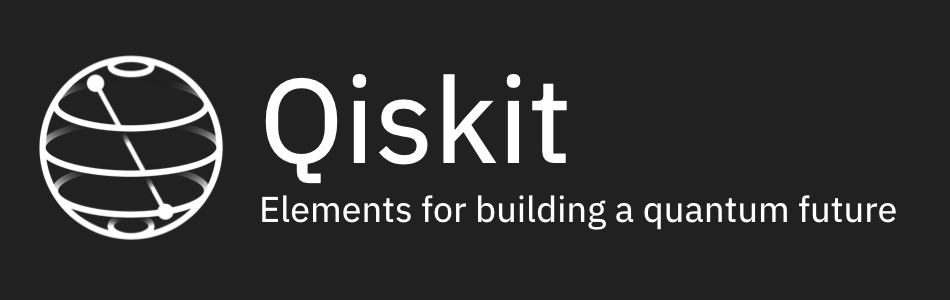

# Qiskit Aer: Pulse simulation of two qubits using a Duffing oscillator model

## Introduction

This notebook shows how to use the Qiskit Aer pulse simulator, which simulates experiments specified as pulse `Schedule` objects at the Hamiltonian level. In particular, we will construct a model of a two qubit system using a Duffing oscillator model, calibrate $\pi$ pulses on each qubit, then observe cross-resonance drive oscillations.

First import general libraries:

In [1]:
import numpy as np
from scipy.optimize import curve_fit, root

# visualization tools
import matplotlib.pyplot as plt
from qiskit.visualization.bloch import Bloch

Import qiskit libraries for working with pulse:

In [2]:
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

Imports for qiskit pulse simulator: 

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

## Duffing system model

A physical model is stored in a `PulseSystemModel` object. This object stores information required to simulate a physical system with pulse instructions.

The function `duffing_system_model` constructs a `PulseSystemModel` representing qubits modeled by Duffing oscillators. The model is specified in terms of the parameters:

-  Each Duffing oscillator is specified by a frequency $\nu$, anharmonicity $\alpha$, and drive strength $r$, which result in the Hamiltonian terms:
\begin{equation}
    \pi(2\nu - \alpha)a^\dagger a + \pi \alpha (a^\dagger a)^2 + 2 \pi r (a + a^\dagger) \times D(t),
\end{equation}
where $D(t)$ is the drive signal for the qubit.
-  A coupling between a pair of oscillators $(l,k)$ is specified by the coupling strength $j$, resulting in an exchange coupling term:
\begin{equation}
    2 \pi j (a_l \otimes a_k^\dagger + a_l^\dagger \otimes a_k).
\end{equation}
- Additionally, a cutoff dimension must be chosen for the model.

Below is an example of the construction of a $2$ Duffing oscillator model with cutoff dimension $3$.

In [4]:
# cutoff dimension
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.003e9)
coupling_dict = {(0,1): 0.002e9}

# time 
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

The function `duffing_system_model` returns a `PulseSystemModel` object representing the specified model.

### Cross-resonance `ControlChannel` indices

In addition to the Hamiltonian, the object contains `ControlChannel` index information for performing cross-resonance drives.

E.g. To get the `ControlChannel` index corresponding to a CR drive on qubit 1 with target 0, call the function `control_channel_index` with the tuple `(1,0)`:

In [5]:
two_qubit_model.control_channel_index((1,0))

1

Hence, to perform a cross-resonance drive on qubit $1$ with target qubit $0$, use `pulse.ControlChannel(1)`.

## Example 1: Calibrating $\pi$ pulses on each qubit using Rabi experiments

In this example, we demonstrate a procedure for calibrating a $\pi$ pulse on each qubit using the simulator and the Duffing model specified above. 

For each qubit, a sequence of experiments is run: each experiment consists of a Gaussian pulse on the qubit, followed by a measurement, with each experiment in the sequence having a subsequently larger amplitude for the Gaussian pulse. By fitting the measurement data, the pulse amplitude for which the qubit completely flips from the ground state to the first excited state is found (i.e. the $\pi$-pulse amplitude).

### Functions to generate the Rabi experiment list, and analyze the output

First, we define a function `rabi_experiments` which, given a qubit index, returns a list of `Schedules` comprising the experiments to observe a Rabi oscillation. 

In [6]:
# number of experiments and drive amplitudes to use in each experiment
exp_num = 41
drive_amps = np.linspace(0, 0.9, exp_num)

# Number of shots for each experiment for collecting measurement statistics
shots = 512

# Properties of the drive pulses
drive_samples = 128
drive_sigma = 16

# Construct measurement commands to be used for all schedules
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='meas_pulse')

acq_cmd=pulse.Acquire(duration=meas_samples)
acq_sched = acq_cmd(pulse.AcquireChannel(0), pulse.MemorySlot(0))
acq_sched += acq_cmd(pulse.AcquireChannel(1), pulse.MemorySlot(1))

# generate Schedules corresponding to Rabi experiments on the specified qubit 
def rabi_experiments(qubit):
    
    # create measurement schedule
    measure_sched = meas_pulse(pulse.MeasureChannel(qubit)) | acq_sched

    # Create schedule
    schedules = []
    for ii, drive_amp in enumerate(drive_amps):
        # drive pulse
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                        amp=drive_amp, 
                                        sigma=drive_sigma, name='rabi_pulse_%d' % ii)

        # add commands to schedule
        schedule = pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)

        schedule += rabi_pulse(pulse.DriveChannel(qubit))
        schedule += measure_sched << schedule.duration

        schedules.append(schedule)
    
    return schedules

Next, we define two functions:
- `qubit_populations_from_memory` - given the results of a simulation, returns the relevant output data
- `rabi_fit_and_plot` - given the qubit index the Rabi experiment was performed on, the list of drive amplitudes used, and the simulation results, fits and plots the output data, and returns the measured amplitude yielding a $\pi$-pulse

In [7]:
# Function for extracting qubit populations from the memory
def qubit_populations_from_memory(sim_results):
    pop_data_Q0 = []
    pop_data_Q1 = []

    for exp_idx in range(exp_num):
        exp_mem = sim_results.get_memory(exp_idx)
        pop_data_Q0.append(np.real(exp_mem[0]))
        pop_data_Q1.append(np.real(exp_mem[1]))
    
    return [pop_data_Q0, pop_data_Q1]



# Function for plotting the data
def rabi_fit_and_plot(qubit_idx, drive_amps, sim_results):
    
    pop_data = qubit_populations_from_memory(sim_results)
    
    # fit the data
    fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
    fitparams, conv = curve_fit(fit_func, drive_amps, pop_data[qubit_idx], [0.5,0.5,0.6,1.5])
    
    #get the pi amplitude by finding the point at which the rabi oscillations achieve the max value 
    pi_amp = root(lambda x: fit_func(x, *fitparams) - 1, x0 = 0.5).x[0]
    
    # Plot the data
    plt.plot(drive_amps, pop_data[0], label='Q0')
    plt.plot(drive_amps, pop_data[1], label='Q1')
    plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='black', linestyle='dashed', label='Fit')
    plt.axvline(pi_amp, color='black', linestyle='dashed')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('Rabi on Q{0}'.format(str(qubit_idx)), fontsize=20)
    plt.grid(True)

    # print and return the pi amp value
    print('Pi Amplitude for qubit {0}: {1}'.format(str(qubit_idx),str(pi_amp)))
    return pi_amp

### Run and fit the Rabi experiment for qubit 0

To run the Rabi experiment on qubit $0$, first assemble the `pulse.Schedule` objects for the experiments into a qobj.

Here, we want to use local oscillators with frequencies automatically computed from Duffing model Hamiltonian.

In [8]:
# instantiate the pulse simulator
backend_sim = PulseSimulator()

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj for a rabi experiment on qubit 0, passing the simulator as the backend
rabi_Q0_qobj = assemble(rabi_experiments(qubit=0),
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:166: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)


Run the simulation and analyze the results:

Pi Amplitude for qubit 0: 0.3114434930759935


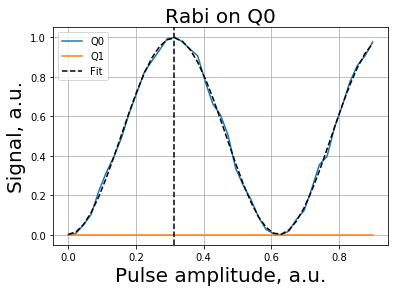

In [9]:
# run the simulation
rabi_Q0_results = backend_sim.run(rabi_Q0_qobj, two_qubit_model).result()

# analyze the data, getting the pi amplitude
pi_amp_Q0 = rabi_fit_and_plot(0, drive_amps, rabi_Q0_results)

Plotted is the averaged counts for observing each qubit in the first excited state. Observe that here, qubit 0 oscillates between the 0 and 1 state, whereas qubit 1, which was not driven, remains in the ground state. The amplitude at which qubit 0 is completely in the first excited state is the desired $\pi$ amplitude.

### Repeat the process on qubit 1

Rerun the same commands for qubit 1. Here, when we `assemble`, we won't specify `qubit_lo_freq`. In this situation, the simulator will try to generate it automatically; in this case the only potential source of the local oscillator frequencies is the Hamiltonian itself, so it will automatically be computed from the drift, resulting in the same `qubit_lo_freq` as was specified in the experiments for qubit $0$.

In [10]:
# assemble the qobj for a rabi experiment on qubit 1, passing the simulator as the backend
rabi_Q1_qobj = assemble(rabi_experiments(qubit=1),
                        backend=backend_sim,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/

Run the experiments and fit the data.

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/aer/pulse/qobj/digest.py:93: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel, so it is beign automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel, ' +


Pi Amplitude for qubit 1: 0.3116230397526249


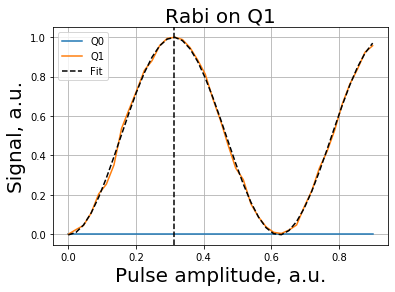

In [11]:
# run the simulation
rabi_Q1_results = backend_sim.run(rabi_Q1_qobj, two_qubit_model).result()

# analyze the data, getting the pi amplitude
pi_amp_Q1 = rabi_fit_and_plot(1, drive_amps, rabi_Q1_results)

We observe similar oscillations, with the roles of qubits 0 and 1 reversed.

## Example 2: Oscillations from cross-resonance drive

Next, we simulate the effects of a cross-resonance drive on qubit $1$ with target qubit $0$, observing that the trajectory and oscillations of qubit $0$ *depends* on thes tate of qubit $1$.

The set up in the experiment is the same to Example 1, but now pulses are performed on the cross-resonance control channel. We also need to observe the oscillations in two situations: when the driven qubit is in the ground state, and when it is in the first excited state. For the latter case, we first excite the driven qubit at the beginning of each experiment using the calibrated $\pi$ pulses from Example 1. 

### Functions to generate the experiment list, and analyze the output

First, we define a function `cr_drive_experiments`, which, given the drive and target indices, and the option to either start with the drive qubit in the ground or excited state, returns a list of experiments for observing the oscillations.

In [12]:
# exp configuration
exps = 41
shots = 512

# Rabi pulse
cr_drive_amps = np.linspace(0, 0.9, exps)
cr_drive_samples = 600
cr_drive_sigma = 4

# store the pi amplitudes from Example 1 in a list
pi_amps = [pi_amp_Q0, pi_amp_Q1]

def cr_drive_experiments(drive_idx, target_idx, flip_drive_qubit = False):

    # create measurement schedule
    measure_sched = acq_sched
    
    # Create schedule
    schedules = []
    for ii, cr_drive_amp in enumerate(cr_drive_amps):
        
        # pulse for flipping drive qubit if desired
        pi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=pi_amps[drive_idx], 
                                       sigma=drive_sigma, name='pi')


        # cr drive pulse
        cr_rabi_pulse = pulse_lib.gaussian_square(duration=cr_drive_samples, 
                                                  amp=cr_drive_amp, 
                                                  risefall=cr_drive_sigma*4,
                                                  sigma=cr_drive_sigma, name='rabi_pulse_%d' % ii)

        # add commands to schedule
        schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)

        # flip drive qubit if desired
        if flip_drive_qubit:
            schedule += pi_pulse(pulse.DriveChannel(drive_idx))
        
        # do cr drive
        # First, get the ControlChannel index for CR drive from drive to target
        cr_idx = two_qubit_model.control_channel_index((drive_idx, target_idx))
        schedule += cr_rabi_pulse(pulse.ControlChannel(cr_idx))  << schedule.duration
        
        
        schedule += measure_sched << schedule.duration

        schedules.append(schedule)
    return schedules

Next we create two functions for observing the data:
- `plot_cr_pop_data` - for plotting the oscillations in the same style as in Example 1
- `plot_bloch_sphere` - for viewing the trajectory of the target qubit on the bloch sphere

In [13]:
def plot_cr_pop_data(drive_idx, target_idx, cr_drive_amps, sim_result):
    amp_data_Q0 = []
    amp_data_Q1 = []

    for exp_idx in range(len(cr_drive_amps)):
        exp_mem = sim_result.get_memory(exp_idx)
        amp_data_Q0.append(np.abs(exp_mem[0]))
        amp_data_Q1.append(np.abs(exp_mem[1]))

    plt.plot(drive_amps, amp_data_Q0, label='Q0')
    plt.plot(drive_amps, amp_data_Q1, label='Q1')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('CR (Target Q{0}, driving on Q{1})'.format(target_idx, drive_idx), fontsize=20)
    plt.grid(True)

def bloch_vectors(drive_idx, drive_energy_level, sim_result):
    
    # get the dim used for simulation
    dim = int(np.sqrt(len(sim_result.get_statevector(0))))
    
    
    # get the relevant dressed state indices
    idx0 = 0
    idx1 = 0
    if drive_idx == 0:
        if drive_energy_level == 0:
            idx0, idx1 = 0, dim
        elif drive_energy_level == 1:
            idx0, idx1 = 1, dim + 1
    if drive_idx == 1:
        if drive_energy_level == 0:
            idx0, idx1 = 0, 1
        elif drive_energy_level == 1:
            idx0, idx1 = dim, dim + 1

    # construct Pauli operators for correct dressed manifold
    state0 = np.array([two_qubit_model.hamiltonian._estates[idx0]])
    state1 = np.array([two_qubit_model.hamiltonian._estates[idx1]])
    
    outer01 = np.transpose(state0)@state1
    outer10 = np.transpose(state1)@state0
    outer00 = np.transpose(state0)@state0
    outer11 = np.transpose(state1)@state1
    
    X = outer01 + outer10
    Y = -1j*outer01 + 1j*outer10
    Z = outer00 - outer11
    
    # function for computing a single bloch vector
    bloch_vec = lambda vec: np.real(np.array([np.conj(vec)@X@vec, np.conj(vec)@Y@vec, np.conj(vec)@Z@vec]))
    
    return [bloch_vec(sim_result.get_statevector(idx)) for idx in range(len(sim_result.results))]

def plot_bloch_sphere(bloch_vectors):
    sphere = Bloch()
    sphere.add_points(np.transpose(bloch_vectors))
    sphere.show()

## Drive qubit 1 to observe CR oscillations on qubit 0

### Qubit 1 in the ground state

First, we drive with both qubit 0 and qubit 1 in the ground state.

In [14]:
# construct experiments
drive_idx = 1
target_idx = 0
flip_drive = False
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/

Run the simulation:

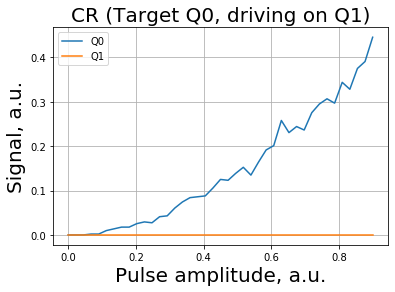

In [15]:
sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, cr_drive_amps, sim_result)

Observe that qubit 1 remains in the ground state, while excitations are driven in qubit 0.

We may also observe the trajectory of qubit 0 on the Bloch sphere:

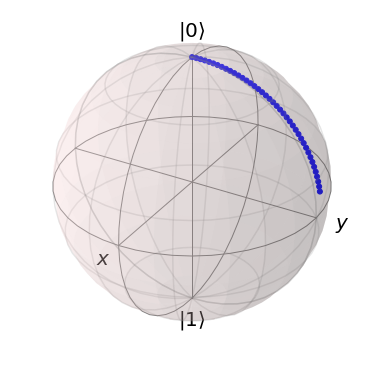

In [16]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

### Qubit 1 in the first excited state

Next, we again perform a CR drive qubit 1 with qubit 0 as the target, but now we start each experiment by flipping qubit 1 into the first excited state. 

In [17]:
# construct experiments, now with flip_drive == True
drive_idx = 1
target_idx = 0
flip_drive = True
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/compiler/assemble.py:169: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  qobj_header=qobj_header, run_config=run_config)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/qobj/converters/pulse_instruction.py:119: DeprecationWarning: "mem_slots" is deprecated and being replaced by "mem_slot"
  return method(self, shift, instruction)
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/

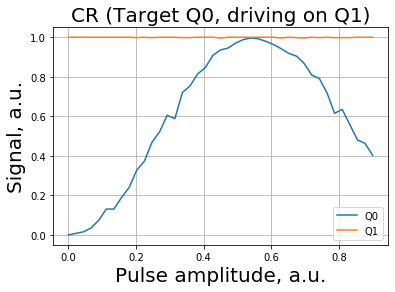

In [18]:
sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, cr_drive_amps, sim_result)

Observe that now qubit 1 is in the excited state, while oscillations are again being driven on qubit 0, now at a different rate as before.

Again, observe the trajectory of qubit 0 on the Bloch sphere:

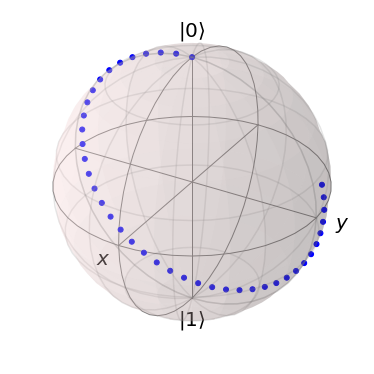

In [19]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

Here we see that qubit 0 takes a *different* trajectory on the Bloch sphere when qubit 1 is in the excited state. This is what enables controlled operations between two qubits.